# This notebook replicates the CNN training cycle taken from the Opensoundscape tutorial. 

The trainign set in this example contains 4 fully annotated recordings. 

I was unable to get the notebook to run on Colab - the session kept crashing once the model started to load in onto the GPU. I tried a few things including reducing the batch size and changing the instance type. Since I was able to run the notebook on my local machine, I don't think memory was the main issue in the crashes. 



# Train a CNN

Convolutional neural networks (CNNs) are popular tools for creating automated machine learning classifiers on images or image-like samples. By converting audio into a two-dimensional frequency vs. time representation such as a spectrogram, we can generate image-like samples that can be used to train CNNs. 

This tutorial demonstrates the basic use of OpenSoundscape's `preprocessors` and `cnn` modules for training CNNs and making predictions using CNNs.

Under the hood, OpenSoundscape uses Pytorch for machine learning tasks. By using the class `opensoundscape.ml.cnn.CNN`, you can train and predict with PyTorch's powerful CNN architectures in just a few lines of code. 

## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

In [1]:
# if this is a Google Colab notebook, install opensoundscape in the runtime environment
if 'google.colab' in str(get_ipython()):
  %pip install opensoundscape

## Setup

### Import needed packages

In [2]:
# the cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape import CNN

#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
import subprocess
from glob import glob
import sklearn
import opensoundscape as opso

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Set random seeds

Set manual seeds for Pytorch and Python. These essentially "fix" the results of any stochastic steps in model training, ensuring that training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### Download files

Training a machine learning model requires some pre-labeled data. These data, in the form of audio recordings or spectrograms, are labeled with whether or not they contain the sound of the species of interest. 

These data can be obtained from online databases such as Xeno-Canto.org, or by labeling one's own ARU data using a program like Cornell's Raven sound analysis software. In this example we are using a set of annotated avian soundscape recordings that were annotated using the software Raven Pro 1.6.4 (Bioacoustics Research Program 2022):

<blockquote><i>An annotated set of audio recordings of Eastern North American birds containing frequency, time, and species information. </i> Lauren M. Chronister,  Tessa A. Rhinehart,  Aidan Place,  Justin Kitzes.
https://doi.org/10.1002/ecy.3329 
</blockquote>

These are the same data that are used by the annotation and preprocessing tutorials, so you can skip this step if you've already downloaded them there.

Download the datasets to your current working directory and unzip them. You can do so by running the cell below OR

- Download and unzip both `annotation_Files.zip` and `mp3_Files.zip` from the https://datadryad.org/stash/dataset/doi:10.5061/dryad.d2547d81z  
- Move the unzipped contents into a subfolder of the current folder called `./annotated_data/`

In [4]:
%%capture
# Note: the "!" preceding each line below allows us to run bash commands in a Jupyter notebook
# If you are not running this code in a notebook, input these commands into your terminal instead
!wget -O annotation_Files.zip https://datadryad.org/stash/downloads/file_stream/641805;
!wget -O mp3_Files.zip https://datadryad.org/stash/downloads/file_stream/641807;
!mkdir annotated_data;
!unzip annotation_Files.zip -d ./annotated_data/Annotation_Files;
!unzip mp3_Files.zip -d ./annotated_data/Recordings;

## Prepare audio data

To prepare audio data for machine learning, we need to convert our annotated data into clip-level labels.

These steps are covered in depth in other tutorials, so we'll just set our clip labels up quickly for this example.

First, get exactly matched lists of audio files and their corresponding selection files:

In [5]:
# Set the current directory to where the dataset is downloaded
dataset_path = Path("./annotated_data/")

# Make a list of all of the selection table files
selection_files = glob(f"{dataset_path}/Annotation_Files/*/*.txt")
selection_files

['annotated_data/Annotation_Files/Recording_1/Recording_1_Segment_31.Table.1.selections.txt',
 'annotated_data/Annotation_Files/Recording_1/Recording_1_Segment_07.Table.1.selections.txt',
 'annotated_data/Annotation_Files/Recording_1/Recording_1_Segment_36.Table.1.selections.txt',
 'annotated_data/Annotation_Files/Recording_1/Recording_1_Segment_04.Table.1.selections.txt',
 'annotated_data/Annotation_Files/Recording_1/Recording_1_Segment_35.Table.1.selections.txt',
 'annotated_data/Annotation_Files/Recording_1/Recording_1_Segment_09.Table.1.selections.txt',
 'annotated_data/Annotation_Files/Recording_1/Recording_1_Segment_03.Table.1.selections.txt',
 'annotated_data/Annotation_Files/Recording_1/Recording_1_Segment_32.Table.1.selections.txt',
 'annotated_data/Annotation_Files/Recording_1/Recording_1_Segment_33.Table.1.selections.txt',
 'annotated_data/Annotation_Files/Recording_1/Recording_1_Segment_02.Table.1.selections.txt',
 'annotated_data/Annotation_Files/Recording_1/Recording_1_Se

In [6]:

# Create a list of audio files, one corresponding to each Raven file
# (Audio files have the same names as selection files with a different extension)
audio_files = [f.replace('Annotation_Files','Recordings').replace('.Table.1.selections.txt','.mp3') for f in selection_files]

In [7]:
!ls annotated_data

README.txt            test_set.csv          valid_set.csv
Recordings            train_and_val_set.csv wav_files
annotation_Files      train_set.csv


Next, convert the selection files and audio files to a `BoxedAnnotations` object, which contains the time, frequency, and label information for all annotations for every recording in the dataset.

In [8]:
from opensoundscape.annotations import BoxedAnnotations
# Create a dataframe of annotations
annotations = BoxedAnnotations.from_raven_files(
    selection_files,
    audio_files)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/annotations.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_annotations = pd.concat(all_file_dfs).reset_index(drop=True)


In [9]:
audio_files

['annotated_data/Recordings/Recording_1/Recording_1_Segment_31.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_07.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_36.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_04.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_35.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_09.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_03.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_32.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_33.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_02.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_08.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_34.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_05.mp3',
 'annotated_data/Recordings/Recording_1/Recording_1_Segment_06.mp3',
 'annotated_data/Recordings/Record

In [10]:
!pip install ffmpeg
import ffmpeg

In [11]:
annotations

,audio_file,raven_file,annotation,start_time,end_time,low_f,high_f,View,Channel,Selection
0,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,BTNW,0.913636,2.202273,4635.1,7439.0,Spectrogram 1,1,1
1,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,EATO,2.236363,2.693182,3051.9,4101.0,Spectrogram 1,1,2
2,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,BTNW,4.234091,6.054545,4196.4,7477.2,Spectrogram 1,1,3
3,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,EATO,5.870454,6.354545,2956.5,4101.0,Spectrogram 1,1,4
4,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,BHCO,6.877640,7.498095,6733.3,10376.5,Spectrogram 1,1,5
...,...,...,...,...,...,...,...,...,...,...
16047,annotated_data/Recordings/Recording_3/Recordin...,annotated_data/Annotation_Files/Recording_3/Re...,EATO,294.434023,296.405887,2454.2,8325.4,Spectrogram 1,1,363
16048,annotated_data/Recordings/Recording_3/Recordin...,annotated_data/Annotation_Files/Recording_3/Re...,EATO,296.704800,297.948665,2340.9,4908.4,Spectrogram 1,1,364
16049,annotated_data/Recordings/Recording_3/Recordin...,annotated_data/Annotation_Files/Recording_3/Re...,BWWA,297.119422,298.170440,4983.9,9401.5,Spectrogram 1,1,365
16050,annotated_data/Recordings/Recording_3/Recordin...,annotated_data/Annotation_Files/Recording_3/Re...,BCCH,297.237338,298.220859,3106.8,3667.8,Spectrogram 1,1,366


In [12]:
!ls annotated_data/

README.txt            test_set.csv          valid_set.csv
Recordings            train_and_val_set.csv wav_files
annotation_Files      train_set.csv


When extracting the downloaded database, there were two folders each containing the source recordings. These were the wav and mp3 folders. I had to renamne the mp3 folder to Recordings to match the path expected by this notebook. 

In [13]:
%%capture
# Parameters to use for label creation
clip_duration = 3.0
clip_overlap = 0.0
min_label_overlap = 0.25
species_of_interest = ["NOCA", "EATO", "SCTA", "BAWW", "BCCH", "AMCR", "NOFL"]

# Create dataframe of one-hot labels
clip_labels = annotations.one_hot_clip_labels(
    clip_duration = clip_duration, 
    clip_overlap = clip_overlap,
    min_label_overlap = min_label_overlap,
    class_subset = species_of_interest # You can comment this line out if you want to include all species.
)

## Create train, validation, and test datasets

To train and test a model, we use three datasets:
* The **training dataset** is used to fit your machine learning model to the audio data. 
* The **validation dataset** is a held-out dataset that is used to select hyperparameters (e.g. how many epochs to train for) during training
* The **test dataset** is another held-out dataset that we use to check how the model performs on data that were not available at all during training.

While both the training and validation datasets are used while trained the model, the test dataset is never touched until the model is fully trained and completed.

The training and validation datasets may be gathered from the same source as each other. In contrast, the test dataset is often gathered from a different source to assess whether the model's performance generalizes to a real-world problem. For example, training and validation data might be drawn from an online database like Xeno-Canto, whereas the testing data is from your own field data. 

### Create a test dataset

We'll separate the test dataset first. For a good assessment of the model's generalization, we want the test set to be independent of the training and validation datasets. For example, we don't want to use clips from the same source recording in the training dataset and the test dataset.

For this example, we'll use the recordings in the folders `Recording_1`, `Recording_2` and `Recording_3` as our training and validation data, and use the recordings in folder `Recording_4` as our test data. 

In [14]:
# Select all files from Recording_4 as a test set
mask = clip_labels.reset_index()['file'].apply(lambda x: 'Recording_4' in x).values
test_set = clip_labels[mask]

# All other files will be used as a training set
train_and_val_set = clip_labels.drop(test_set.index)

# Save .csv tables of the training and validation sets to keep a record of them
train_and_val_set.to_csv("./annotated_data/train_and_val_set.csv")
test_set.to_csv("./annotated_data/test_set.csv")

If you wanted, you could load the training and testing set from these saved CSV files.

In [15]:
train_and_val_set = pd.read_csv('./annotated_data/train_and_val_set.csv',index_col=[0,1,2])
test_set = pd.read_csv('./annotated_data/test_set.csv',index_col=[0,1,2])

### Split training and validation datasets

Now, separate the remaining non-test data into training and validation datasets.

The idea of keeping a separate validation dataset is that, throughout training, we can 'peek' at the performance on the validation set to choose hyperparameters. (This is in contrast to the test dataset, which we will not look at until we've finished training our model.)

One important hyperparameter is the number of **epochs** to train to, in order to prevent overfitting. Each epoch includes one round of fitting on each training sample. 

If a model's performance on a training dataset continues to improve as it trains, but its performance on the validation dataset plateaus, this could incate the model is **overfitting** on the training dataset, learning information specific to those particular samples instead of gaining the ability to generalize to new data.

In [16]:
# Split our training data into training and validation sets
train_df, valid_df = sklearn.model_selection.train_test_split(train_and_val_set, test_size=0.1, random_state=0)

In [17]:
train_df.to_csv("./annotated_data/train_set.csv")
valid_df.to_csv("./annotated_data/valid_set.csv")

### Resample data for even class representation

Before training, we will balance the number of samples of each class in the training set. This helps the model learn all of the classes, rather than paying too much attention to the classes with the most labeled annotations. 

In [18]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) so that all classes have 800 samples
balanced_train_df = resample(train_df,n_samples_per_class=800,random_state=0)

## Set up model

Now we create a model object. We have to select several parameters when creating this object: its `architecture`, `classes`, and `sample_duration`. 

Some additional parameters can also be changed at this step, such as the preprocessor used to create spectrograms and the shape of the spectrograms. 

For more detail on this step, see the ["Customize CNN training"]("tutorials/CNN.html") tutorial.


### Create CNN object

Now, create a CNN object with this architecture, the classes we put into the dataframe above, and the same sample duration as we selected above.

The first time you run this script for a particular architecture, OpenSoundscape will download the desired architecture.

In [19]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration = clip_duration #3s, selected above
)

### Check model device

If a GPU is available on your computer, the CNN object automatically selects it for accellerating performance. You can override `.device` to use a specific device such as `cpu` or `cuda:3`

In [20]:
print(f'model.device is: {model.device}')

model.device is: mps


### Set up WandB model logging

While this step is optional, it is very helpful for model training. In this step, we set up model logging on a service called **Weights & Biases** (AKA WandB). 

Weights & Biases is a free website you can use to monitor model training. It is integrated with OpenSoundscape to include helpful functions such as checking on your model's training progress in real time, visualizing the spectrograms created for training your model, comparing multiple tries at training the same model, and more. For more information, check out this [blog post](https://wandb.ai/wandb_fc/repo-spotlight/reports/Community-Spotlight-OpenSoundscape--Vmlldzo0MDcwMTI4). 

The instructions below will help you set up `wandb` logging:

* Create an account on the [Weights and Biases website](https://wandb.ai/). 
* The first time you use `wandb`, you'll need to run `wandb.login()` in Python or `wandb login` on the command line, then enter the API key from your [settings](https://wandb.ai/settings) page
* In a Python script where you want to log model training, use `wandb.init()` as demonstrated below. The "Entity" or team option allows runs and projects to be shared across members in a group, making it easy to collaborate and see progress of other team members' runs.


As training progresses, performance metrics will be plotted to the wandb logging platform and visible on this run's web page. For example, this [wandb web page](https://wandb.ai/kitzeslab/opensoundscape%20training%20demo/runs/w1xyk7zr/workspace?workspace=user-samlapp) shows the content logged to wandb when this notebook was run by the Kitzes Lab. By default, OpenSoundscape + WandB integration creates several pages with information about the model:

- Overview: hyperparameters, run description, and hardware available during the run
- Charts: "Samples" panel with audio and images of preprocessed samples (useful for checking that your preprocessing performs as expected and your labels are correct)
- Charts: graphs of each class's performance metrics over training time
- Model: summary of model architecture
- Logs: standard output of training script
- System: computational performance metrics including memory, CPU use, etc

When training several models and comparing performance, the "Project" page of WandB provides comparisons of metrics and hyperparameters across training runs.

In [21]:
import wandb


In [23]:
try:
    wandb.login(relogin=True)
    wandb_session = wandb.init(
        project='osfl',
    )
except: #if wandb.init fails, don't use wandb logging
    print('failed to create wandb session. wandb session will be None')
    wandb_session = None

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


## Train the CNN

Finally, train the CNN for two epoch. Typically, we would train the model for more than two epochs, but because training is slow and is much better done outside of a Jupyter Notebook, we just include this as a short demonstration of training.

Each **epoch** is one pass-through of all of the samples in the training dataset, plus running predictions on the validation dataset. 

Each epoch is composed of smaller groups of samples called **batches**. The machine learning model predicts on every sample in the batch, then the model weights are updated based on those samples. Larger batches can increase training speed, but require more memory. If you get a memory error, try reducing the batch size.

We use default training parameters, but many aspects of CNN training can be customized (see the "Customize CNN training" tutorial for examples).

In [24]:
checkpoint_folder = Path("model_training_checkpoints")
checkpoint_folder.mkdir(exist_ok=True)

training on mps (Apple Silicon GPU) requires PyTorch >= 2.1.0. If we have an older 

In [25]:
# if model.device ==  torch.device('mps'):
#     model.device=torch.device('cpu')

In [27]:
#%%capture --no-stdout --no-display
# Uncomment the line above to silence outputs from this cell

model.train(
    balanced_train_df, 
    valid_df, 
    epochs = 6, 
    batch_size = 64, 
    log_interval = 100, #log progress every 100 batches
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    wandb_session = wandb_session,
    save_interval = 10, #save checkpoint every 10 epochs
    save_path = checkpoint_folder #location to save checkpoints
)


Training Epoch 2


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 2 [batch 0/88, 0.00%] 
	DistLoss: 0.249
Metrics:
Metrics:
	MAP: 0.855

Validation.


  0%|          | 0/8 [00:00<?, ?it/s]

Metrics:
	MAP: 0.754

Training Epoch 3


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 3 [batch 0/88, 0.00%] 
	DistLoss: 0.245
Metrics:
Metrics:
	MAP: 0.904

Validation.


  0%|          | 0/8 [00:00<?, ?it/s]

Metrics:
	MAP: 0.754

Training Epoch 4


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 4 [batch 0/88, 0.00%] 
	DistLoss: 0.191
Metrics:
Metrics:
	MAP: 0.928

Validation.


  0%|          | 0/8 [00:00<?, ?it/s]

Metrics:
	MAP: 0.771

Training Epoch 5


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 5 [batch 0/88, 0.00%] 
	DistLoss: 0.167
Metrics:
Metrics:
	MAP: 0.948

Validation.


  0%|          | 0/8 [00:00<?, ?it/s]

Metrics:
	MAP: 0.792

Training Epoch 6


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 6 [batch 0/88, 0.00%] 
	DistLoss: 0.138
Metrics:
Metrics:
	MAP: 0.959

Validation.


  0%|          | 0/8 [00:00<?, ?it/s]

Metrics:
	MAP: 0.796

Training Epoch 7


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 7 [batch 0/88, 0.00%] 
	DistLoss: 0.137
Metrics:
Metrics:
	MAP: 0.967

Validation.


  0%|          | 0/8 [00:00<?, ?it/s]

Metrics:
	MAP: 0.808

Best Model Appears at Epoch 7 with Validation score 0.808.


Here's an example of some of the charts on wandb after training a model for a few epochs. Some of the bird species didn't have such high recall and precision scores, but the Resnet34 model was able to generalise to recognise other american robins from amongst vocalizations not present in the training set, but from the same recording. 

There's a second test set of recordings from a different location. 

<!-- ![Screenshot 2024-02-18 at 14.23.16.png](<attachment:Screenshot 2024-02-18 at 14.23.16.png>) -->
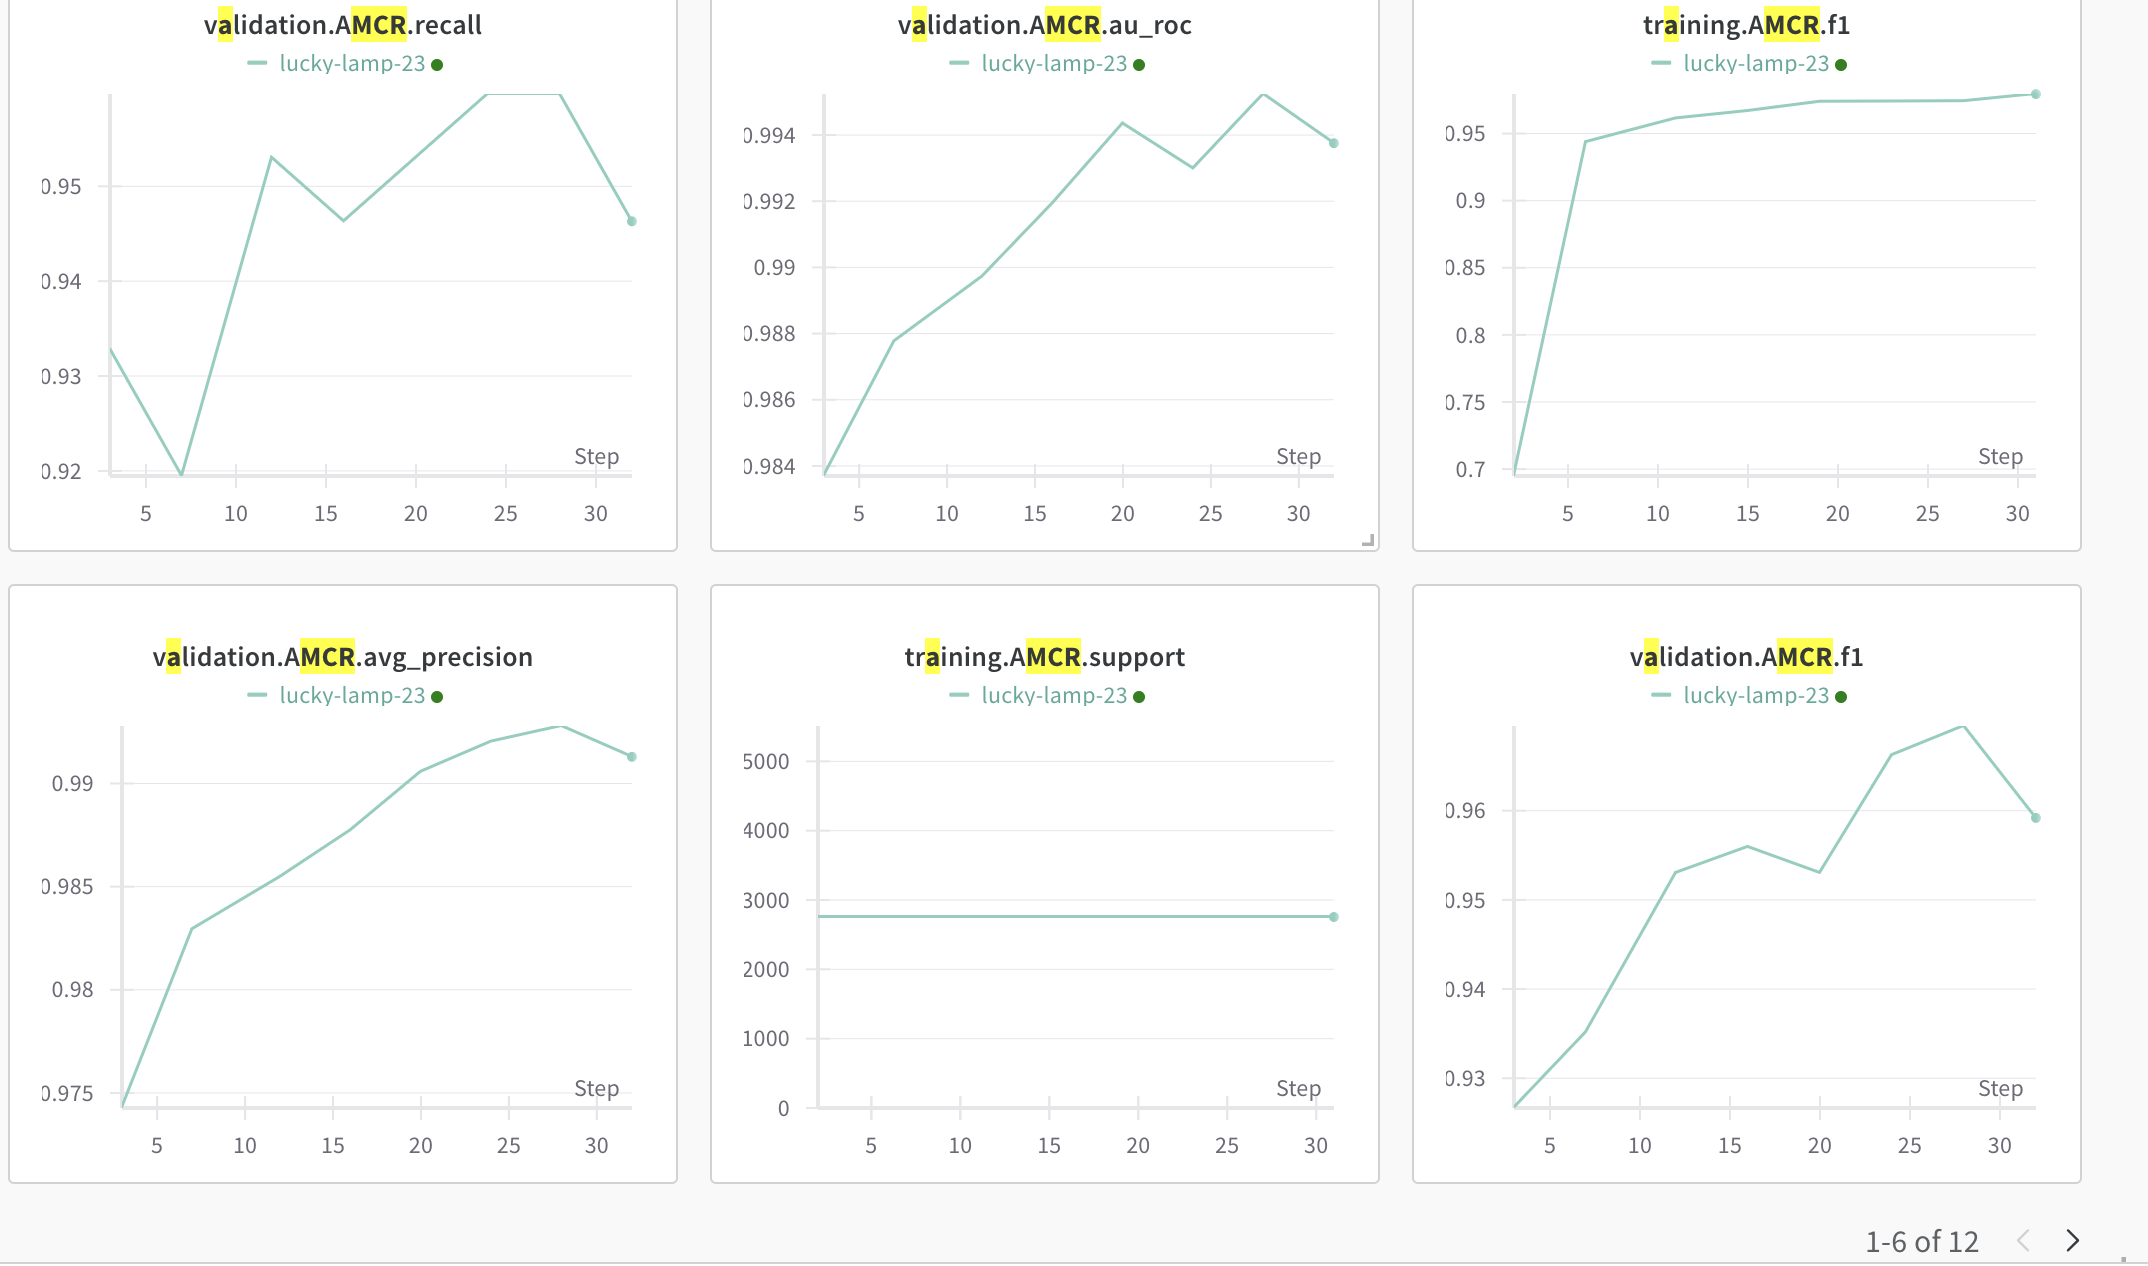

## Let's take a look at the validation set used to evaluate this model during training.

In [34]:
valid_df.head()

,,,NOCA,EATO,SCTA,BAWW,BCCH,AMCR,NOFL
file,start_time,end_time,,,,,,,
annotated_data/Recordings/Recording_1/Recording_1_Segment_14.mp3,75.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annotated_data/Recordings/Recording_1/Recording_1_Segment_05.mp3,12.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annotated_data/Recordings/Recording_2/Recording_2_Segment_14.mp3,60.0,63.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
annotated_data/Recordings/Recording_1/Recording_1_Segment_12.mp3,9.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
annotated_data/Recordings/Recording_1/Recording_1_Segment_23.mp3,9.0,12.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


The validation set contains a random sample of clips from areas 1, 2 and 3 - so the model has never seen these clips before, but it has seen clips from the same location. Let's see how the model performs on these clips compared with the ones in the withheld test set

In [145]:
valid_preds = model.predict(valid_df, batch_size=64)
test_preds = model.predict(test_set, batch_size=64)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Multi target metrics on the validation set:

In [157]:
sum(amcr_df.AMCR)

149.0

# Measure performance on the validation and test sets

In [164]:
# drop all columns except amcr
# use multi target evaluation function

valid_metrics = opso.metrics.multi_target_metrics(valid_df.values, valid_preds, valid_df.columns, threshold=0.5)['AMCR']
test_set_metrics = opso.metrics.multi_target_metrics(test_set.values, test_preds, test_set.columns, threshold=0.5)['AMCR']

pd.DataFrame([valid_metrics, test_set_metrics], index=['valid', 'test_set'])

# save the validation and test sets
test_set.to_csv("./annotated_data/test_set.csv")
valid_df.to_csv("./annotated_data/valid_set.csv")  

$$
precision = [
\frac{TP}{TP + FP}
]
$$ 

$$
recall = [
\frac{TP}{TP + FN}
]

$$
$$
f1 = [
\frac{2 * precision * recall}{precision + recall}
]


$$
$$
accuracy = [
\frac{TP + TN}{TP + TN + FP + FN}
]


$$
$$
specificity = [
\frac{TN}{TN + FP}
]
$$

$$ 
support = [
TP + FN
]
$$



There's about 4600 clips in the training set and about 510 in the validation set for the AMRO for this example. The test set contains 196

In [160]:
len(valid_df.AMCR),len(train_df.AMCR), sum(test_set.AMCR == 1), sum(valid_df.AMCR == 1)

(510, 4590, 196, 149)

In [95]:
len(test_set), len(valid_df)

(2600, 510)

In [94]:
test_set.head()

NOCA  \
file                                               start_time end_time         
annotated_data/Recordings/Recording_4/Recording... 0.0        3.0        0.0   
                                                   3.0        6.0        1.0   
                                                   6.0        9.0        1.0   
                                                   9.0        12.0       0.0   
                                                   12.0       15.0       0.0   

                                                                        EATO  \
file                                               start_time end_time         
annotated_data/Recordings/Recording_4/Recording... 0.0        3.0        0.0   
                                                   3.0        6.0        1.0   
                                                   6.0        9.0        1.0   
                                                   9.0        12.0       1.0   
                                                   12.0       15.0       1.0   

                                                                        SCTA  \
file                                               start_time end_time         
annotated_data/Recordings/Recording_4/Recording... 0.0        3.0        0.0   
                                                   3.0        6.0        0.0   
                                                   6.0        9.0        0.0   
                                                   9.0        12.0       0.0   
                                                   12.0       15.0       0.0   

                                                                        BAWW  \
file                                               start_time end_time         
annotated_data/Recordings/Recording_4/Recording... 0.0        3.0        0.0   
                                                   3.0        6.0        0.0   
                                                   6.0        9.0        0.0   
                                                   9.0        12.0       0.0   
                                                   12.0       15.0       0.0   

                                                                        BCCH  \
file                                               start_time end_time         
annotated_data/Recordings/Recording_4/Recording... 0.0        3.0        0.0   
                                                   3.0        6.0        0.0   
                                                   6.0        9.0        0.0   
                                                   9.0        12.0       0.0   
                                                   12.0       15.0       0.0   

                                                                        AMCR  \
file                                               start_time end_time         
annotated_data/Recordings/Recording_4/Recording... 0.0        3.0        1.0   
                                                   3.0        6.0        0.0   
                                                   6.0        9.0        0.0   
                                                   9.0        12.0       1.0   
                                                   12.0       15.0       1.0   

                                                                        NOFL  
file                                               start_time end_time        
annotated_data/Recordings/Recording_4/Recording... 0.0        3.0        0.0  
                                                   3.0        6.0        0.0  
                                                   6.0        9.0        0.0  
                                                   9.0        12.0       0.0  
                                                   12.0       15.0       0.0

Does the model do as well on the withheld test set as it did on the validation set?

In [99]:
opso.metrics.multi_target_metrics(test_set.values, test_preds, test_set.columns, threshold=0.5)['AMCR']

{'au_roc': 0.7497580563007232,
 'avg_precision': 0.1913537095348884,
 'precision': 0.2553191489361702,
 'recall': 0.12244897959183673,
 'f1': 0.16551724137931037,
 'support': 196}

No, the model does not do as well on the test set as it did on the validation set.

In [144]:
model.save('opso_model')

# do the other pretrained models do any better?
- first I'll try to find and load the model which was trained by this opensoundscape tutorial, then I'll try birdnet. 

In [143]:
torch.hub.list('kitzeslab/bioacoustics-model-zoo')
# All of these models require tensorflow, so I'll evaluate them in a separate notebook.

Using cache found in /Users/mikeg/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


['BirdNET', 'Perch', 'SeparationModel', 'YAMNet', 'rana_sierrae_cnn']

Once this is finished running, you have trained the CNN. 

**Clean up:** Run the following cell to delete the files created in this tutorial. However, these files are used in other tutorials, so you may wish not to delete them just yet.

In [ ]:
# import shutil
# shutil.rmtree('./annotated_data')
# shutil.rmtree('./wandb')
# shutil.rmtree('./model_training_checkpoints')
# Path('annotation_Files.zip').unlink()
# Path('mp3_Files.zip').unlink()